Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..','..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings('ignore')
import facts
from facts.models import customXGB
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if, save_rules_by_if
from facts.fairness_metrics_aggr import get_diff_table, get_comb_df, get_analysis_dfs, get_diff_real_diff_drop,get_other_ranks_divided,get_map_metric_to_max_rank
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
cost_budget = 10
top_count = 20
c_inf = 5

# Dataset

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


In [4]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = ['hours-per-week']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
%%time

model = customXGB(n_estimators=300, max_depth=5)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 13.3 s


array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0])

In [7]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     10205
           1       0.78      0.66      0.72      3362

    accuracy                           0.87     13567
   macro avg       0.84      0.80      0.82     13567
weighted avg       0.87      0.87      0.87     13567



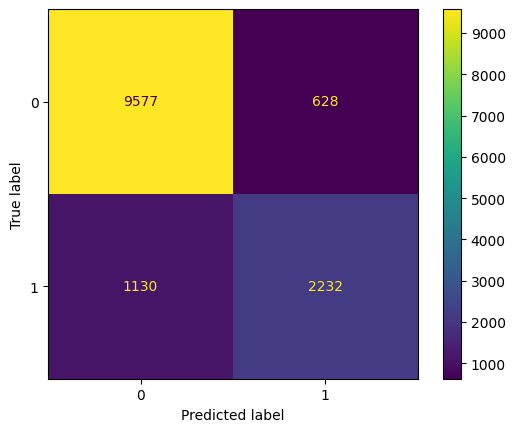

In [8]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Rules

In [9]:
# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='sex',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = True
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [10]:
## Use this for loading rules from disk
rules_by_if = load_rules_by_if("rulesAdultFairTest-xgboost.data")
## Use this for saving rules on disk
# save_rules_by_if("rulesAdultFairTest-xgboost.data", rules_by_if)

In [11]:
num_features_ = ['education-num', 'capital-gain', 'capital-loss']
cate_features_ = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features_ = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

In [12]:
# rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)

In [12]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if("rulesAdultFairTest-xgboost_cumulative.data")

## Use this for saving rules on disk
# save_rules_by_if("rulesAdultFairTest-xgboost_cumulative.data", rules_with_cumulative)

In [13]:
rules_with_atomic_correctness = rules_by_if
rules_with_cumulative_correctness = rules_with_cumulative

In [14]:
feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

facts.update_costs_cumulative(rules_with_cumulative_correctness, params)

# Macro Viewpoint

## Equal Cost of Effectiveness (Macro)

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Cost of Effectiveness (Macro) (threshold = 0.7)'
)

If age = (26.0, 34.0], marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 4.64% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 71.34%.
		Aggregate cost of the above recourses = 120.00
	Protected Subgroup ' Female', 5.53% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 71.17%.
		Aggregate cost of the above recourses = 20.00
	Bias against  Male due to Equal Cost of Effectiveness (Macro) (threshold = 0.7). Unfairness score = 100.
If Workclass =  Private, marital-status =  Never-married, occupation =  Prof-specialty, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.32% covered
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 74.71%.
		Aggregate cost of the above recourses = 110.

## Equal Choice for Recourse(Macro)

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Choice for Recourse(Macro) (threshold = 0.7)'
)

If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, hours-per-week = OverTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.48% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 70.41%.
		Aggregate cost of the above recourses = -1.00
	Protected Subgroup ' Female', 1.54% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 88.71%.
		Make age = (41.0, 50.0], hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 82.26%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 82.26%.
		Make age = (34.0, 41.0], hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 77.42%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with effect

# Micro Viewpoint

##  Equal Conditional Mean Recourse

If age = (34.0, 41.0], capital-loss = 0, native-country =  United-States, race =  Black:
	Protected Subgroup ' Male', 1.26% covered
		Make age = (41.0, 50.0] with effectiveness 6.02% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 6.02% and counterfactual cost = 100.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 7.23% and counterfactual cost = 110.0.
		Make age = (50.0, 90.0], race =  White with effectiveness 7.23% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 26.67
	Protected Subgroup ' Female', 2.79% covered
		Make age = (41.0, 50.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make race =  White with effectiveness 2.68% and counterfactual cost = 100.0.
		Make age = (50.0, 90.0], race =  White with effectiveness 2.68% and counterfactual cost = 110.0.
		Make age = (41.0, 50.0], race =  White with effectiveness 2.68% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 100.00
	Bias 

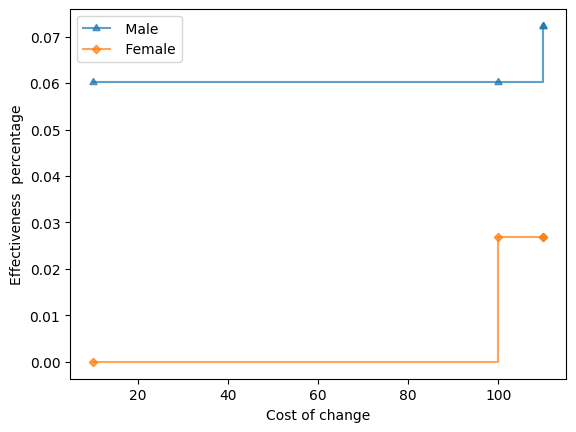

If occupation =  Handlers-cleaners, race =  White:
	Protected Subgroup ' Male', 6.91% covered
		Make occupation =  Transport-moving with effectiveness 0.66% and counterfactual cost = 4.
		Make occupation =  Protective-serv with effectiveness 1.31% and counterfactual cost = 4.
		Make occupation =  Machine-op-inspct with effectiveness 1.53% and counterfactual cost = 4.
		Make occupation =  Adm-clerical with effectiveness 1.75% and counterfactual cost = 4.
		Make occupation =  Craft-repair with effectiveness 1.97% and counterfactual cost = 4.
		Make occupation =  Sales with effectiveness 3.94% and counterfactual cost = 4.
		Make occupation =  Prof-specialty with effectiveness 8.75% and counterfactual cost = 4.
		Make occupation =  Tech-support with effectiveness 10.07% and counterfactual cost = 4.
		Make occupation =  Exec-managerial with effectiveness 10.94% and counterfactual cost = 4.
		Make occupation =  Exec-managerial, race =  Black with effectiveness 10.94% and counterfactual cost 

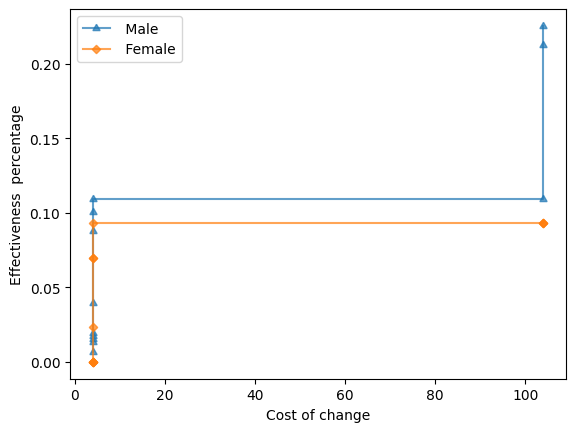

If age = (26.0, 34.0], native-country =  United-States, race =  Black:
	Protected Subgroup ' Male', 2.03% covered
		Make age = (41.0, 50.0] with effectiveness 6.72% and counterfactual cost = 10.
		Make race =  White with effectiveness 6.72% and counterfactual cost = 100.
		Make age = (34.0, 41.0], race =  White with effectiveness 6.72% and counterfactual cost = 110.
		Make age = (41.0, 50.0], race =  White with effectiveness 6.72% and counterfactual cost = 110.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup ' Female', 3.24% covered
		Make age = (41.0, 50.0] with effectiveness 3.85% and counterfactual cost = 10.
		Make race =  White with effectiveness 3.85% and counterfactual cost = 100.
		Make age = (34.0, 41.0], race =  White with effectiveness 6.92% and counterfactual cost = 110.
		Make age = (41.0, 50.0], race =  White with effectiveness 7.69% and counterfactual cost = 110.
		Aggregate cost of the above recourses = 60.00
	Bias against  Female due to Equal Condit

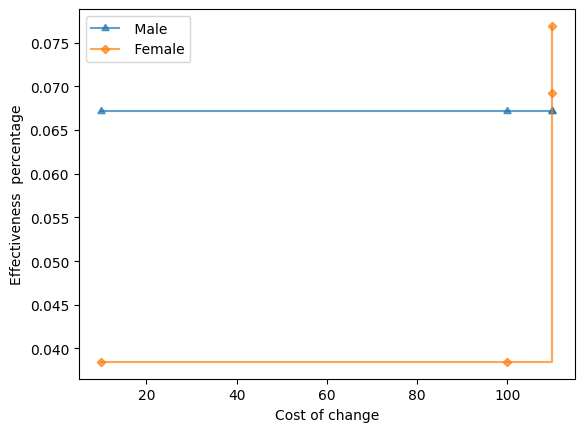

If race =  Black, relationship =  Own-child:
	Protected Subgroup ' Male', 1.75% covered
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.
		Make race =  White, relationship =  Married with effectiveness 0.00% and counterfactual cost = 105.
		Make race =  White, relationship =  Not-in-family with effectiveness 0.00% and counterfactual cost = 105.
		Make race =  White, relationship =  Unmarried with effectiveness 0.00% and counterfactual cost = 105.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 0.86% and counterfactual cost = 105.
		Aggregate cost of the above recourses = 105.00
	Protected Subgroup ' Female', 2.76% covered
		Make relationship =  Married with effectiveness 0.90% and counterfactual cost = 5.
		Make race =  White, relationship =  Married with effectiveness 0.90% and counterfactual cost = 105.
		Make race =  White, relationship =  Not-in-family with effectiveness 0.90% and counterfactual cost = 105.
		Make ra

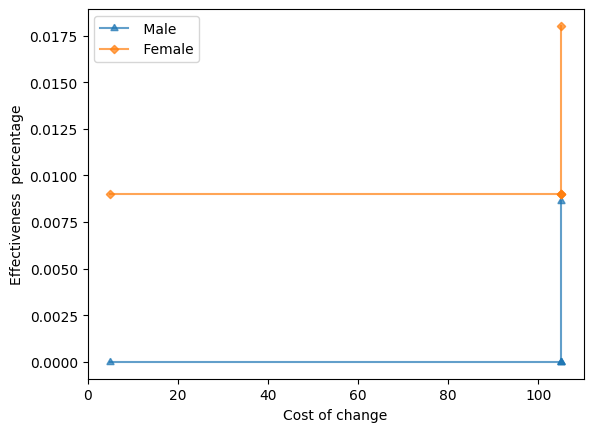

If hours-per-week = OverTime, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Male', 1.10% covered
		Make hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 2.
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Prof-specialty with effectiveness 5.48% and counterfactual cost = 4.
		Make occupation =  Exec-managerial with effectiveness 26.03% and counterfactual cost = 4.
		Make hours-per-week = FullTime, occupation =  Sales with effectiveness 26.03% and counterfactual cost = 6.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with effectiveness 26.03% and counterfactual cost = 6.
		Make hours-per-week = FullTime, occupation =  Craft-repair with effectiveness 26.03% and counterfactual cost = 6.
		Make hours-per-week = FullTime, occupation =  Protective-serv with effectiveness 26.03% and counter

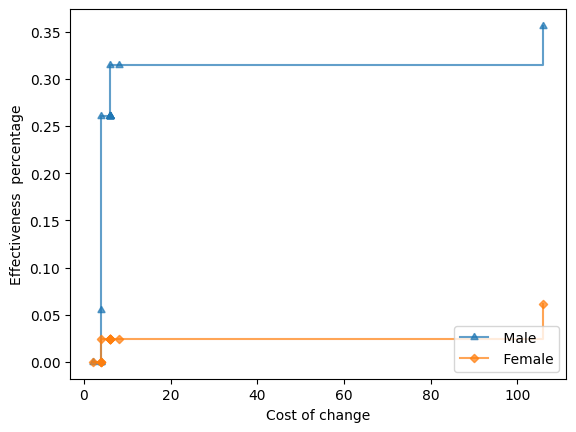

If hours-per-week = PartTime, marital-status =  Never-married, occupation =  Other-service, race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 1.15% covered
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with effectiveness 0.00% and counterfactual cost = 16.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with effectiveness 0.00% and counterfactual cost = 18.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relationship =  Married with effectiveness 0.00% and counterfactual cost = 18.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Sales, relationship =  Married with effectiveness 0.00% and counterfactual cost = 18.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relation

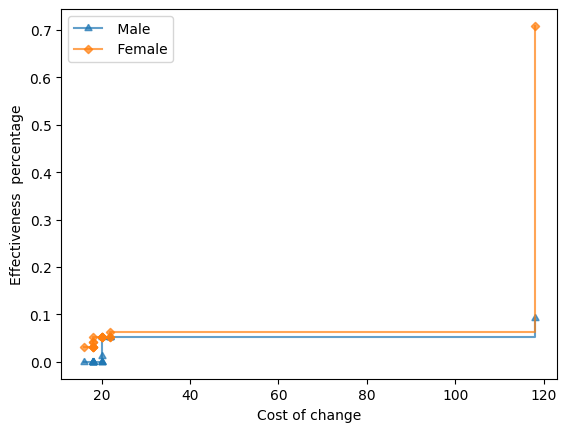

If hours-per-week = OverTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 18.58% covered
		Make hours-per-week = FullTime with effectiveness 0.73% and counterfactual cost = 2.
		Make hours-per-week = BrainDrain with effectiveness 4.07% and counterfactual cost = 2.
		Make hours-per-week = MidTime with effectiveness 4.15% and counterfactual cost = 4.
		Make hours-per-week = PartTime with effectiveness 4.15% and counterfactual cost = 6.
		Make race =  Black with effectiveness 7.41% and counterfactual cost = 100.
		Make hours-per-week = FullTime, race =  Black with effectiveness 7.41% and counterfactual cost = 102.
		Aggregate cost of the above recourses = 45.10
	Protected Subgroup ' Female', 10.40% covered
		Make hours-per-week = FullTime with effectiveness 0.00% and counterfactual cost = 2.
		Make hours-per-week = BrainDrain with effectiveness 0.24% and counterfactual cost = 2.
		Make hours-per-week = MidTime with effectiveness 0.24% and counterfactual co

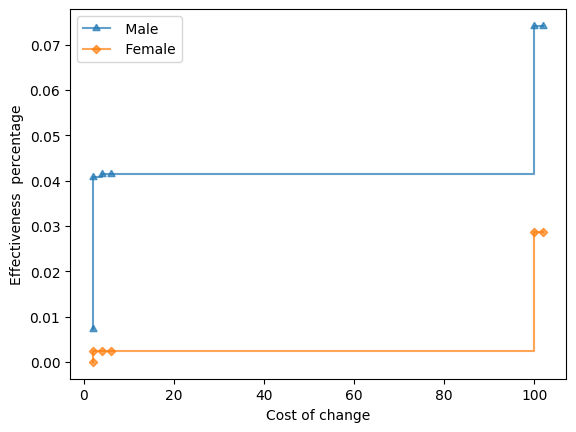

If hours-per-week = MidTime, race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 2.00% covered
		Make relationship =  Married with effectiveness 0.00% and counterfactual cost = 5.
		Make hours-per-week = FullTime, relationship =  Married with effectiveness 0.00% and counterfactual cost = 7.
		Make hours-per-week = PartTime, relationship =  Married with effectiveness 0.00% and counterfactual cost = 7.
		Make hours-per-week = FullTime, relationship =  Not-in-family with effectiveness 0.00% and counterfactual cost = 7.
		Make hours-per-week = OverTime, relationship =  Married with effectiveness 0.00% and counterfactual cost = 9.
		Make hours-per-week = OverTime, relationship =  Not-in-family with effectiveness 0.00% and counterfactual cost = 9.
		Make hours-per-week = BrainDrain, relationship =  Married with effectiveness 0.00% and counterfactual cost = 11.
		Make hours-per-week = BrainDrain, relationship =  Not-in-family with effectiveness 0.00% and counterfactual cost

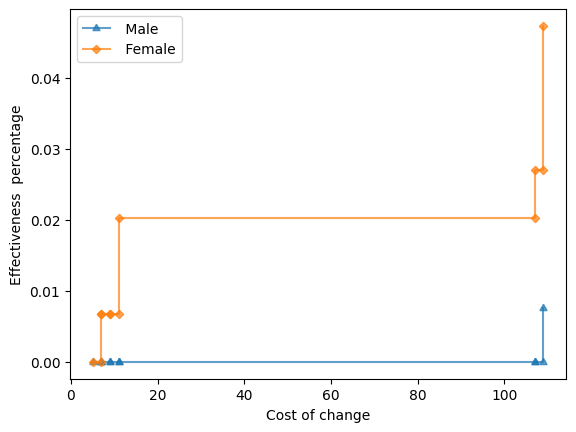

If age = (16.999, 26.0], race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 9.74% covered
		Make age = (34.0, 41.0], relationship =  Not-in-family with effectiveness 0.00% and counterfactual cost = 15.
		Make age = (26.0, 34.0], relationship =  Not-in-family with effectiveness 0.00% and counterfactual cost = 15.
		Make age = (26.0, 34.0], relationship =  Married with effectiveness 0.16% and counterfactual cost = 15.
		Make age = (34.0, 41.0], relationship =  Married with effectiveness 1.86% and counterfactual cost = 15.
		Make age = (34.0, 41.0], race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.02% and counterfactual cost = 115.
		Aggregate cost of the above recourses = 22.69
	Protected Subgroup ' Female', 13.04% covered
		Make age = (34.0, 41.0], relationship =  Not-in-family with effectiveness 0.19% and counterfactual cost = 15.
		Make age = (26.0, 34.0], relationship =  Not-in-family with effectiveness 0.19% and counterfactual cost = 15.
	

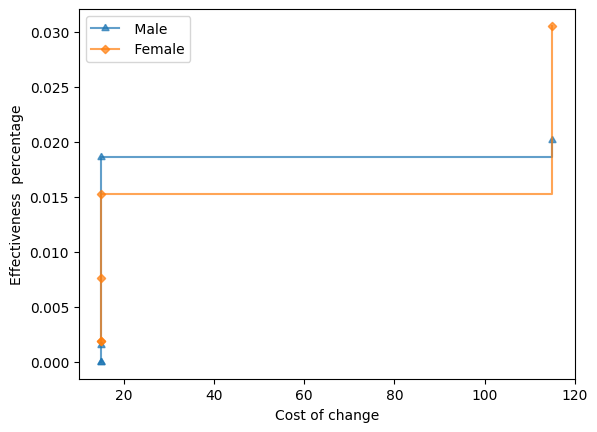

If capital-loss = 0, native-country =  United-States, occupation =  Exec-managerial, race =  White:
	Protected Subgroup ' Male', 5.42% covered
		Make occupation =  Sales with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Transport-moving with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 1.96% and counterfactual cost = 4.0.
		Make occupation =  Protective-serv with effectiveness 4.19% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 19.27% and counterfactual cost = 4.0.
		Make race =  Black with effectiveness 19.27% and counterfactual cost = 100.0.
		Aggregate cost of the above recourses = 4.00
	Protected Subgroup ' Female', 8.41% covered
		Make occupation =  Sales with effectiveness 0.00% 

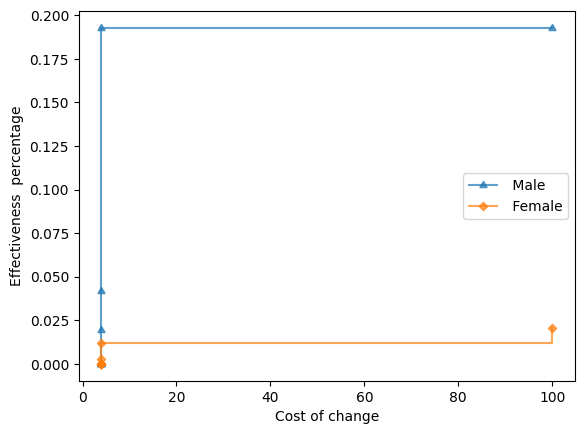

If age = (26.0, 34.0], marital-status =  Divorced, native-country =  United-States, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.15% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 9.21% and counterfactual cost = 10.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 18.42% and counterfactual cost = 20.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 25.00% and counterfactual cost = 20.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, race =  Black, relationship =  Married with effectiveness 39.47% and counterfactual cost = 120.
		Aggregate cost of the above recourses = 54.33
	Protected Subgroup ' Female', 1.54% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.03% and counterfactual cost = 10.
		Make age = (34.0, 41.0], marital

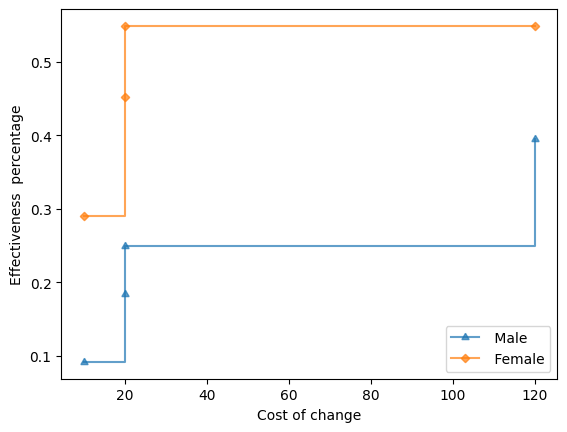

If age = (26.0, 34.0], capital-loss = 0, marital-status =  Never-married, native-country =  United-States, race =  Black:
	Protected Subgroup ' Male', 1.12% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with effectiveness 8.11% and counterfactual cost = 15.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 8.11% and counterfactual cost = 105.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, race =  White with effectiveness 9.46% and counterfactual cost = 115.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, race =  White with effectiveness 9.46% and counterfactual cost = 115.0.
		Aggregate cost of the above recourses = 29.29
	Protected Subgroup ' Female', 1.92% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse with effectiveness 7.79% and counterfactual cost = 15.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 7.79% and counterfactual cost =

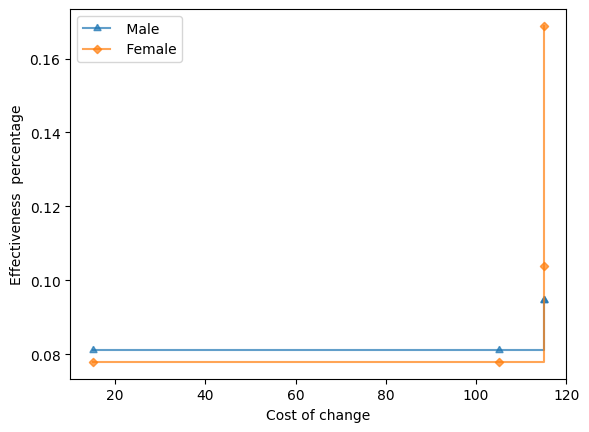

In [22]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False,
    metric_name = 'Equal Conditional Mean Recourse'
)

## Equal Cost of Effectiveness (Micro)

If age = (26.0, 34.0], marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 4.64% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 30.29% and counterfactual cost = 10.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 40.39% and counterfactual cost = 20.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 50.49% and counterfactual cost = 20.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, race =  Black, relationship =  Married with effectiveness 55.70% and counterfactual cost = 120.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 62.54% and counterfactual cost = 120.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship

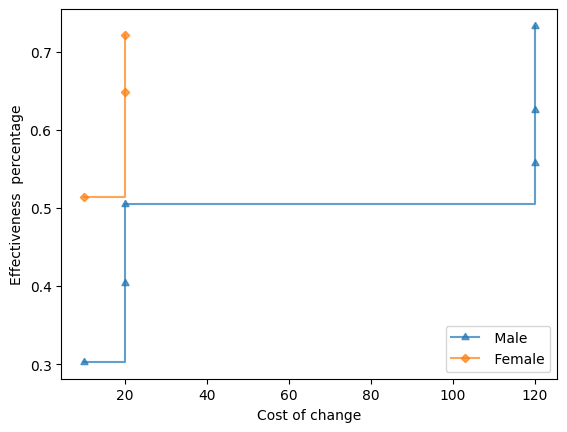

If capital-loss = 0, marital-status =  Never-married, occupation =  Exec-managerial, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.60% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 57.55% and counterfactual cost = 10.0.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving, relationship =  Married with effectiveness 57.55% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married with effectiveness 57.55% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 57.55% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Protective-serv, relationship =  Married with effectiveness 57.55% and counterfactual cost = 14.0.
		Make marital-status =  Married-civ-spouse, occupation =  Sales, relati

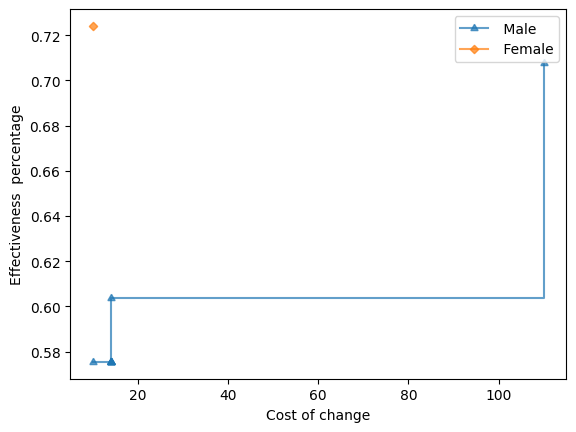

If age = (41.0, 50.0], capital-loss = 0, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.16% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 50.65% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 51.95% and counterfactual cost = 20.0.
		Make marital-status =  Married-civ-spouse, race =  Black, relationship =  Married with effectiveness 57.14% and counterfactual cost = 110.0.
		Make marital-status =  Married-civ-spouse, race =  Asian-Pac-Islander, relationship =  Married with effectiveness 71.43% and counterfactual cost = 110.0.
		Aggregate cost of the above recourses = 110.00
	Protected Subgroup ' Female', 1.34% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 77.78% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1

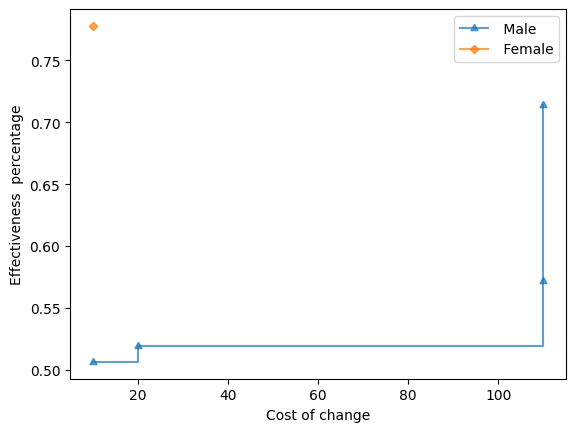

If Workclass =  Private, occupation =  Adm-clerical, race =  White, relationship =  Married:
	Protected Subgroup ' Male', 1.65% covered
		Make Workclass =  Federal-gov with effectiveness 45.87% and counterfactual cost = 2.
		Make occupation =  Machine-op-inspct with effectiveness 45.87% and counterfactual cost = 4.
		Make occupation =  Transport-moving with effectiveness 46.79% and counterfactual cost = 4.
		Make occupation =  Craft-repair with effectiveness 46.79% and counterfactual cost = 4.
		Make occupation =  Sales with effectiveness 46.79% and counterfactual cost = 4.
		Make occupation =  Prof-specialty with effectiveness 46.79% and counterfactual cost = 4.
		Make occupation =  Tech-support with effectiveness 52.29% and counterfactual cost = 4.
		Make occupation =  Exec-managerial with effectiveness 54.13% and counterfactual cost = 4.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with effectiveness 55.05% and counterfactual cost = 6.
		Make Workclass =  Self-emp-not

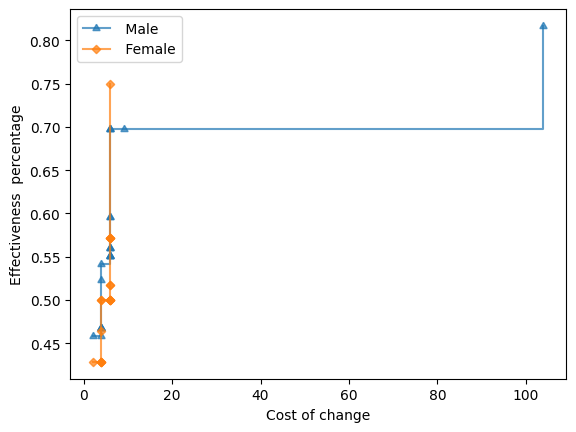

If marital-status =  Never-married, occupation =  Prof-specialty, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.21% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 55.48% and counterfactual cost = 10.
		Make marital-status =  Married-civ-spouse, occupation =  Transport-moving, relationship =  Married with effectiveness 55.48% and counterfactual cost = 14.
		Make marital-status =  Married-civ-spouse, occupation =  Machine-op-inspct, relationship =  Married with effectiveness 56.85% and counterfactual cost = 14.
		Make marital-status =  Married-civ-spouse, occupation =  Craft-repair, relationship =  Married with effectiveness 57.53% and counterfactual cost = 14.
		Make marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relationship =  Married with effectiveness 57.53% and counterfactual cost = 14.
		Make marital-status =  Married-civ-spouse, occupation =  Protective-serv, relationship =  Married

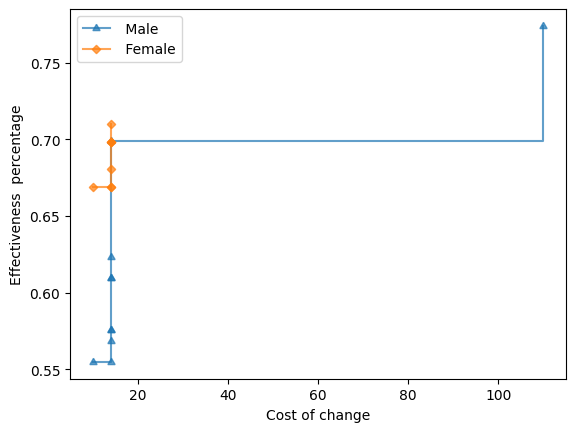

If age = (26.0, 34.0], hours-per-week = OverTime, marital-status =  Never-married, native-country =  United-States, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.33% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 44.32% and counterfactual cost = 10.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 46.59% and counterfactual cost = 12.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 47.73% and counterfactual cost = 12.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 55.68% and counterfactual cost = 20.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 69.32% and counterfactual cost = 20.
		Make age = (34.0, 41.0], hours-per-week = FullTime, marital-status =  Ma

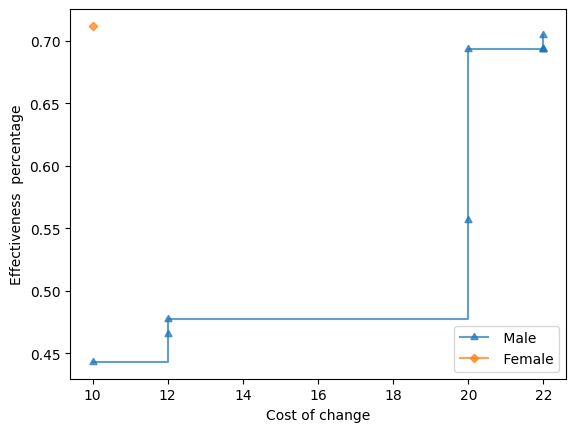

If Workclass =  Private, age = (26.0, 34.0], capital-loss = 0, hours-per-week = OverTime, marital-status =  Never-married, native-country =  United-States, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.04% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 43.48% and counterfactual cost = 10.0.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 43.48% and counterfactual cost = 12.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 53.62% and counterfactual cost = 20.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 69.57% and counterfactual cost = 20.0.
		Make age = (34.0, 41.0], hours-per-week = FullTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 69.57% and counterfactual cost = 22.0.
		Make

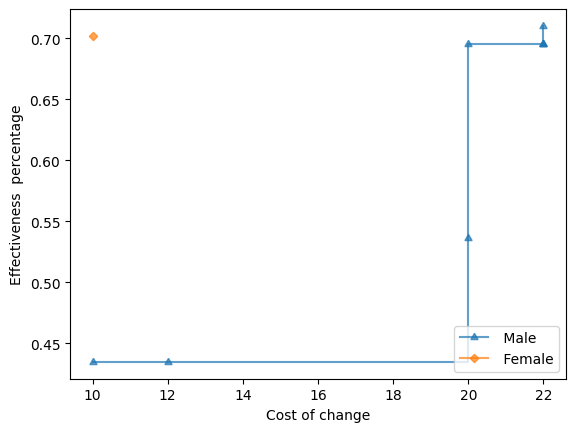

If age = (26.0, 34.0], education-num = 13, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.54% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.75% and counterfactual cost = 10.
		Make education-num = 14, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 69.61% and counterfactual cost = 13.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 75.49% and counterfactual cost = 20.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 2.17% covered
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 79.31% and counterfactual cost = 10.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Cost of Effectiveness (Micro) (threshold = 0.7). Unfairness score = 10.
	Cumulative effectiveness plot for the above recourses:


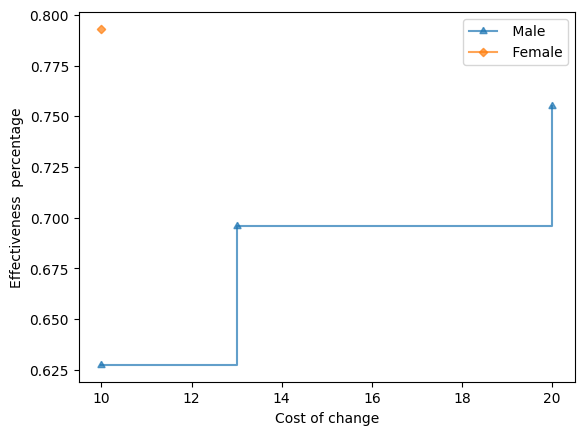

In [23]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold = 0.7,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False,
    metric_name = 'Equal Cost of Effectiveness (Micro) (threshold = 0.7)'
)

## Equal Effectiveness

If age = (16.999, 26.0], capital-loss = 0, education-num = 10, marital-status =  Never-married, native-country =  United-States, race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 3.09% covered
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.96% and counterfactual cost = 20.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 7.84% and counterfactual cost = 20.0.
		Make age = (34.0, 41.0], education-num = 11, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 8.82% and counterfactual cost = 23.0.
		Make age = (34.0, 41.0], education-num = 12, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 11.76% and counterfactual cost = 26.0.
		Aggregate cost of the above recourses = 0.12
	Protected Subgroup ' Female', 5.00% covered
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse, rela

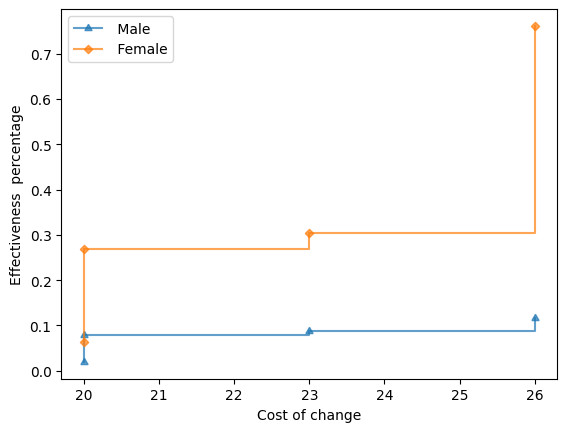

If age = (16.999, 26.0], education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, native-country =  United-States, relationship =  Own-child:
	Protected Subgroup ' Male', 1.77% covered
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 1.71% and counterfactual cost = 22.
		Make age = (34.0, 41.0], education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 4.27% and counterfactual cost = 23.
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 5.13% and counterfactual cost = 25.
		Aggregate cost of the above recourses = 0.05
	Protected Subgroup ' Female', 1.05% covered
		Make age = (34.0, 41.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 16.67% and counterfactual cost = 22.
		M

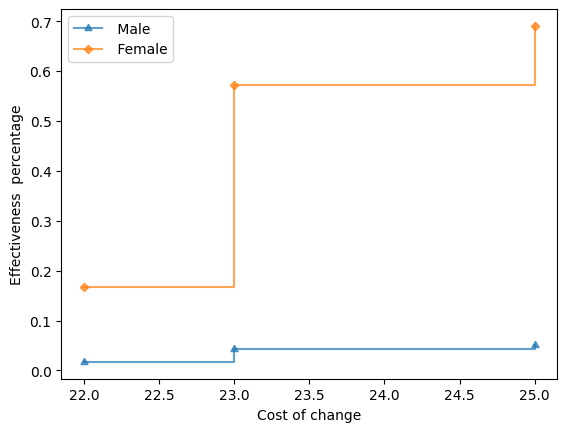

If hours-per-week = PartTime, marital-status =  Never-married, occupation =  Other-service, race =  White, relationship =  Own-child:
	Protected Subgroup ' Male', 1.15% covered
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with effectiveness 0.00% and counterfactual cost = 16.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Prof-specialty, relationship =  Married with effectiveness 0.00% and counterfactual cost = 18.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Exec-managerial, relationship =  Married with effectiveness 0.00% and counterfactual cost = 18.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Sales, relationship =  Married with effectiveness 0.00% and counterfactual cost = 18.
		Make hours-per-week = FullTime, marital-status =  Married-civ-spouse, occupation =  Adm-clerical, relation

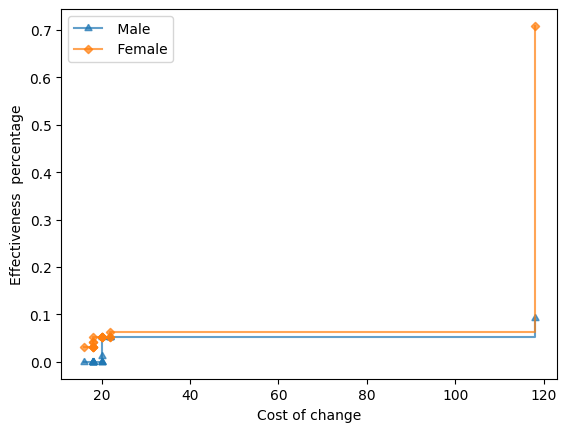

If age = (16.999, 26.0], capital-loss = 0, education-num = 9, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Male', 1.86% covered
		Make age = (34.0, 41.0], education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 4.07% and counterfactual cost = 23.0.
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 6.50% and counterfactual cost = 25.0.
		Aggregate cost of the above recourses = 0.07
	Protected Subgroup ' Female', 1.24% covered
		Make age = (34.0, 41.0], education-num = 10, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 46.00% and counterfactual cost = 23.0.
		Make age = (34.0, 41.0], education-num = 10, hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 62.00% and counterfactual cost = 25

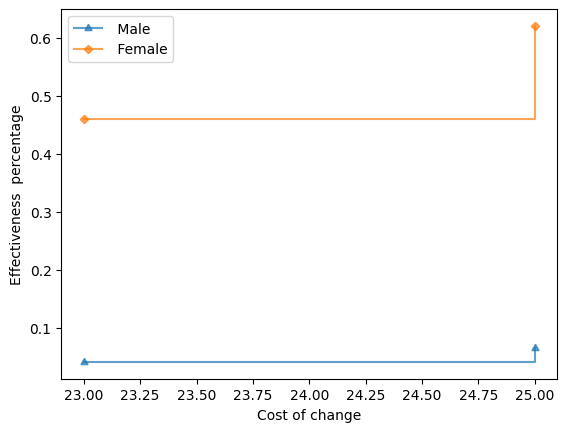

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.04% covered
		Make occupation =  Prof-specialty with effectiveness 33.33% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 52.17% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.52% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 1.52% covered
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.64% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 1.64% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.02
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.549.
	Cumulative 

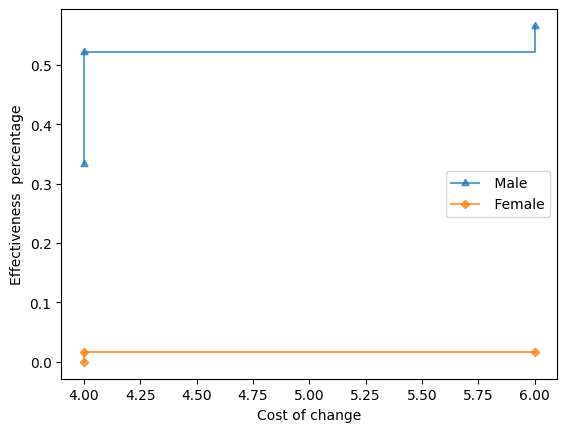

If age = (50.0, 90.0], native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.89% covered
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Prof-specialty with effectiveness 28.80% and counterfactual cost = 4.
		Make occupation =  Exec-managerial with effectiveness 40.00% and counterfactual cost = 4.
		Make occupation =  Tech-support with effectiveness 56.80% and counterfactual cost = 4.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 1.84% covered
		Make occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Prof-specialty with effectiveness 1.35% and counterfactual cost = 4.
		Make occupation =  Adm-clerical with effectiveness 2.7

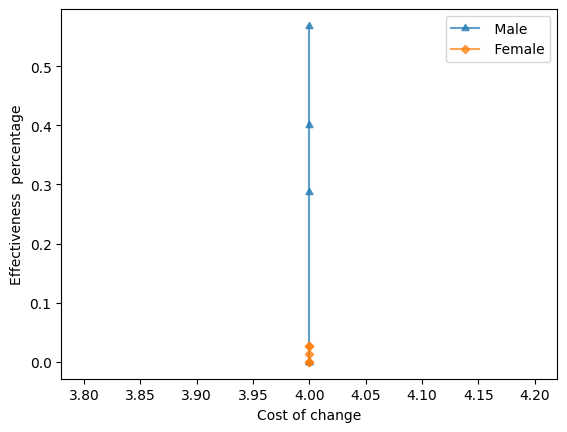

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, capital-loss = 0, occupation =  Sales:
	Protected Subgroup ' Male', 1.01% covered
		Make occupation =  Prof-specialty with effectiveness 34.33% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 52.24% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.72% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 1.57% covered
		Make occupation =  Prof-specialty with effectiveness 1.59% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 3.17% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 3.17% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.03
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.535.
	Cumulative effectiveness p

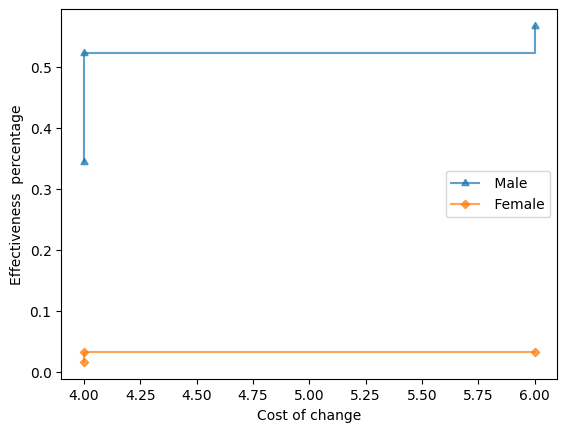

If Workclass =  Private, age = (16.999, 26.0], native-country =  United-States, relationship =  Married:
	Protected Subgroup ' Male', 3.30% covered
		Make age = (26.0, 34.0] with effectiveness 7.80% and counterfactual cost = 10.
		Make age = (34.0, 41.0] with effectiveness 14.68% and counterfactual cost = 10.
		Make Workclass =  Local-gov, age = (26.0, 34.0] with effectiveness 14.68% and counterfactual cost = 12.
		Make Workclass =  Self-emp-not-inc, age = (34.0, 41.0] with effectiveness 14.68% and counterfactual cost = 12.
		Make Workclass =  Local-gov, age = (34.0, 41.0] with effectiveness 16.06% and counterfactual cost = 12.
		Make Workclass =  Self-emp-inc, age = (34.0, 41.0] with effectiveness 22.48% and counterfactual cost = 12.
		Make Workclass =  Federal-gov, age = (34.0, 41.0] with effectiveness 27.52% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 0.28
	Protected Subgroup ' Female', 1.05% covered
		Make age = (26.0, 34.0] with effectiveness 28.57% and

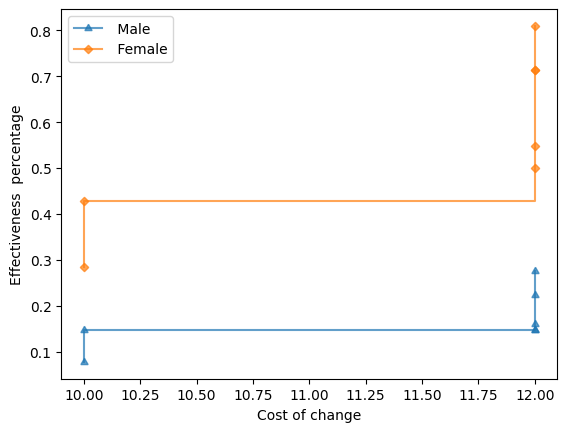

If age = (50.0, 90.0], capital-loss = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.94% covered
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 28.12% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 39.84% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 56.25% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 0.56
	Protected Subgroup ' Female', 1.94% covered
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.28% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 2.56% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical wit

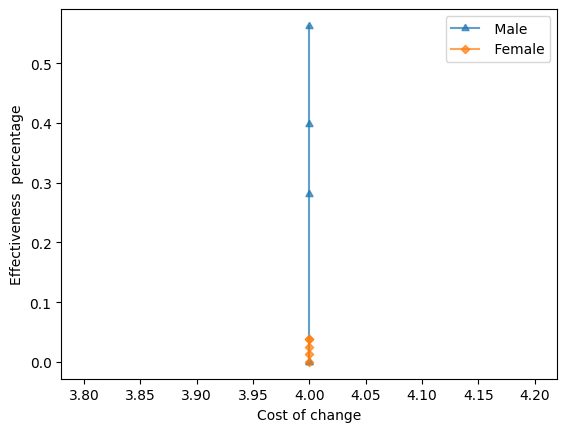

In [28]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
    
)

## Fair Effectiveness-Cost Trade-Off

In [32]:
# taken from the other notebooks
affected_pop_sizes = {" Male": 6732, " Female": 4106}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative_correctness,
    affected_pop_sizes,
    top_count=top_count
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=affected_pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    # show_cumulative_plots=True
)

If Workclass =  Private, capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 62.90% covered out of 6732
		Make capital-gain = 5178 with effectiveness 52.93% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 85.81% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 86.32% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 99.93% and counterfactual cost = 0.15.
		Make Workclass =  Self-emp-not-inc with effectiveness 99.93% and counterfactual cost = 2.0.
		Make Workclass =  Local-gov with effectiveness 99.93% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 99.93% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 99.93% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 99.93% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 99.93% and counterfactual cost = 100.0.
		Make race =  Asi

## Equal Effectiveness within Budget (Micro)

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.04% covered
		Make occupation =  Prof-specialty with effectiveness 33.33% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 52.17% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.52% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 1.52% covered
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.64% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 1.64% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.02
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.549.
	Cumulative 

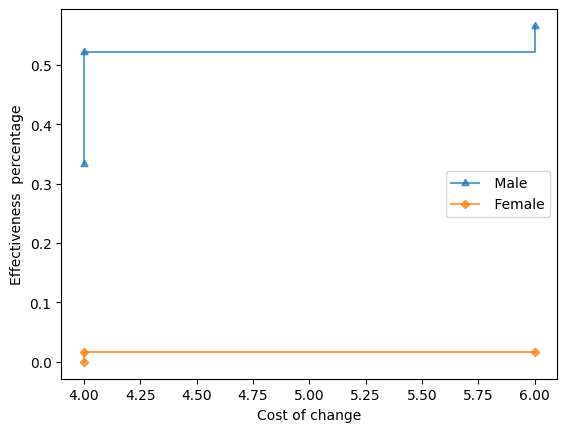

If age = (50.0, 90.0], native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.89% covered
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Prof-specialty with effectiveness 28.80% and counterfactual cost = 4.
		Make occupation =  Exec-managerial with effectiveness 40.00% and counterfactual cost = 4.
		Make occupation =  Tech-support with effectiveness 56.80% and counterfactual cost = 4.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 1.84% covered
		Make occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.
		Make occupation =  Prof-specialty with effectiveness 1.35% and counterfactual cost = 4.
		Make occupation =  Adm-clerical with effectiveness 2.7

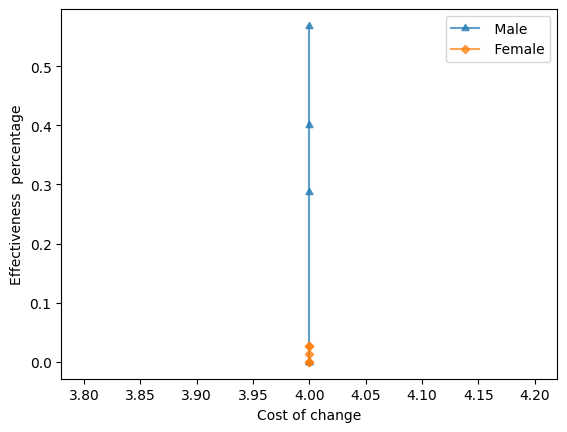

If Workclass =  Private, age = (50.0, 90.0], capital-gain = 0, capital-loss = 0, occupation =  Sales:
	Protected Subgroup ' Male', 1.01% covered
		Make occupation =  Prof-specialty with effectiveness 34.33% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 52.24% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 56.72% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.57
	Protected Subgroup ' Female', 1.57% covered
		Make occupation =  Prof-specialty with effectiveness 1.59% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 3.17% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 3.17% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.03
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.535.
	Cumulative effectiveness p

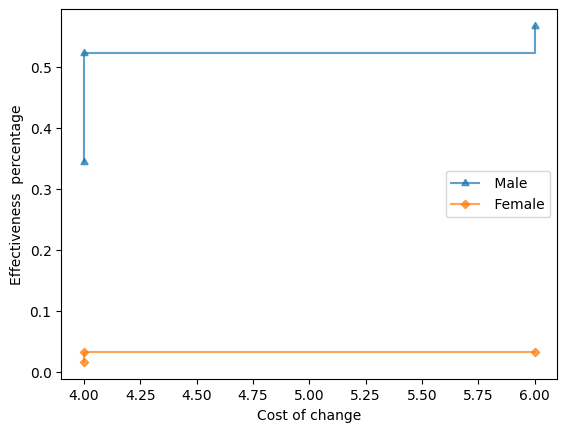

If age = (50.0, 90.0], capital-loss = 0, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.94% covered
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 28.12% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 39.84% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 56.25% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 0.56
	Protected Subgroup ' Female', 1.94% covered
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 1.28% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 2.56% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical wit

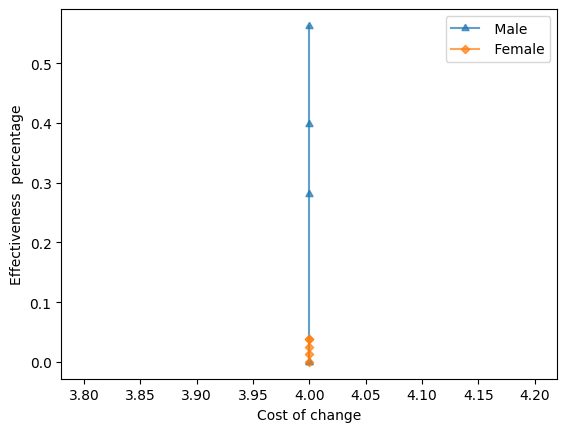

If Workclass =  Private, age = (50.0, 90.0], capital-loss = 0, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.04% covered
		Make occupation =  Prof-specialty with effectiveness 30.43% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 46.38% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 50.72% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup ' Female', 1.42% covered
		Make occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 0.00% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-inc, occupation =  Exec-managerial with effectiveness 0.00% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 0.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.50

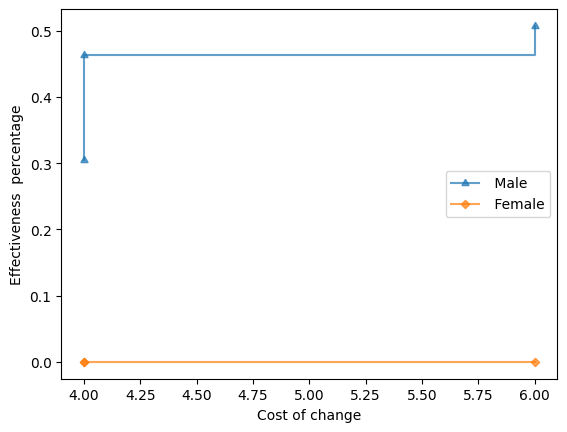

If age = (50.0, 90.0], capital-gain = 0, capital-loss = 0, education-num = 10, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 1.03% covered
		Make hours-per-week = OverTime with effectiveness 51.47% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.51
	Protected Subgroup ' Female', 1.32% covered
		Make hours-per-week = OverTime with effectiveness 1.89% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.02
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.496.
	Cumulative effectiveness plot for the above recourses:


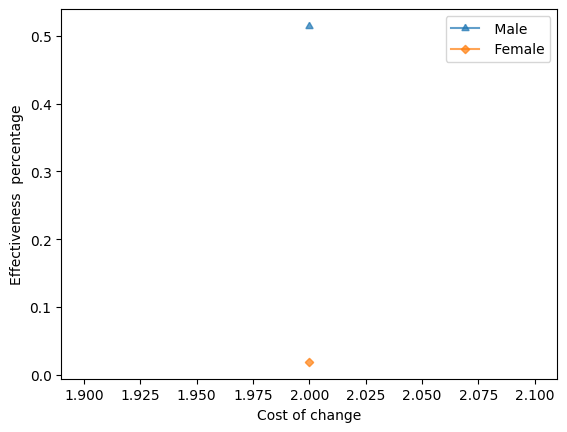

In [30]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cost_threshold = cost_budget,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

## Get ranking of subgroups based on metrics

In [23]:
from facts.fairness_metrics_aggr import make_table, auto_budget_calculation

In [24]:
rules_with_both = {}
for ifc, all_thens in rules_with_cumulative_correctness.items():
    new_all_thens = {}
    for sg, (cov, thens_cum) in all_thens.items():
        thens_atom = rules_with_atomic_correctness[ifc][sg][1]
        thens_atom_dict = {then: atom_cor for then, atom_cor in thens_atom}
        new_all_thens[sg] = (cov, [(then, thens_atom_dict[then], cumcor) for then, cumcor, _cost in thens_cum])
    rules_with_both[ifc] = new_all_thens

In [25]:
budgets = auto_budget_calculation(rules_with_cumulative_correctness, cor_thres=0.5, percentiles=[0.3, 0.6, 0.9])

df = make_table(
    rules_with_both,
    sensitive_attribute_vals=[" Male", " Female"],
    effectiveness_thresholds=[0.3, 0.7],
    cost_budgets=budgets,
    params=params
)
# dropping 'weighted-average' and 'mean-cost-cinf'
df.drop(['weighted-average', 'mean-cost-cinf'], axis=1, inplace=True)

In [26]:
df[('Fair Effectiveness-Cost Trade-Off', 'bias')] = df[('Fair Effectiveness-Cost Trade-Off', 'bias')].str.replace(" ", "")

In [27]:
#table of differences between Male and Female for each metric

diff = get_diff_table(df, sensitive_attribute_vals=[" Male", " Female"], with_abs = True)
diff = diff.set_index('subgroup')
ranked = diff.drop(columns=[('Fair Effectiveness-Cost Trade-Off','bias')]).mask(diff == 0).rank(ascending = False,axis=0,method='dense')
ranked = ranked.replace(np.nan,"Fair")

In [28]:
rev_bias_metrics = ['Equal Effectiveness', 'Equal Effectiveness within Budget']
comb_df = get_comb_df(df, ranked, diff, rev_bias_metrics, sensitive_attribute_vals=[" Male", " Female"])
diff_real_val, _, = get_diff_real_diff_drop(df, diff, sensitive_attribute_vals=[" Male", " Female"])
analysis_df,rank_analysis_df = get_analysis_dfs(comb_df,diff_real_val, rev_bias_metrics, ranked, sensitive_attribute_vals=["Male", "Female"], percentage=0.1)

In [29]:
comb_df.head()

(Equal Cost of Effectiveness(Macro), 0.3)  \
                                                                                       rank   
subgroup                                                                                      
capital-loss = 0                                                                        1.0   
capital-gain = 0                                                                       Fair   
capital-gain = 0, capital-loss = 0                                                     Fair   
native-country =  United-States                                                        Fair   
capital-loss = 0, native-country =  United-States                                       1.0   

                                                                      \
                                                  score bias against   
subgroup                                                               
capital-loss = 0                                    inf       Female   
capital-gain = 0                                    0.0         Fair   
capital-gain = 0, capital-loss = 0                  0.0         Fair   
native-country =  United-States                     0.0         Fair   
capital-loss = 0, native-country =  United-States   inf       Female   

                                                  (Equal Cost of Effectiveness(Macro), 0.7)  \
                                                                                       rank   
subgroup                                                                                      
capital-loss = 0                                                                       Fair   
capital-gain = 0                                                                       20.0   
capital-gain = 0, capital-loss = 0                                                     20.0   
native-country =  United-States                                                        Fair   
capital-loss = 0, native-country =  United-States                                      Fair   

                                                                          \
                                                      score bias against   
subgroup                                                                   
capital-loss = 0                                   0.000000         Fair   
capital-gain = 0                                   0.119211       Female   
capital-gain = 0, capital-loss = 0                 0.119211       Female   
native-country =  United-States                    0.000000         Fair   
capital-loss = 0, native-country =  United-States  0.000000         Fair   

                                                  (Equal Choice for Recourse, 0.3)  \
                                                                              rank   
subgroup                                                                             
capital-loss = 0                                                              10.0   
capital-gain = 0                                                              12.0   
capital-gain = 0, capital-loss = 0                                             9.0   
native-country =  United-States                                               Fair   
capital-loss = 0, native-country =  United-States                             10.0   

                                                                      \
                                                  score bias against   
subgroup                                                               
capital-loss = 0                                    3.0       Female   
capital-gain = 0                                    1.0       Female   
capital-gain = 0, capital-loss = 0                  4.0       Female   
native-country =  United-States                     0.0         Fair   
capital-loss = 0, native-country =  United-States   3.0       Female   

                                                  (Equal Choice for Recourse

In [30]:
analysis_df

,Rank = 1 Count,Male bias against Count,Female bias against Count,Top 10% Male bias against Count,Top 10% Female bias against Count
"(Equal Cost of Effectiveness(Macro), 0.3)",2125,1663,1380,189,115
"(Equal Cost of Effectiveness(Macro), 0.7)",322,460,165,56,6
"(Equal Choice for Recourse, 0.3)",3,2294,1719,345,56
"(Equal Choice for Recourse, 0.7)",1,710,229,88,5
Equal Effectiveness,1,4472,5419,389,600
"(Equal Effectiveness within Budget, 5.072980729807298)",1,1783,4310,54,555
"(Equal Effectiveness within Budget, 10.031030310303102)",1,3831,4608,260,583
"(Equal Effectiveness within Budget, 20.4366391184573)",1,4232,5276,298,652
"(Equal Cost of Effectiveness(Micro), 0.3)",2390,1807,1716,179,173
"(Equal Cost of Effectiveness(Micro), 0.7)",422,595,166,72,4


In [31]:
rank_analysis_df

,"(Equal Cost of Effectiveness(Macro), 0.3)","(Equal Cost of Effectiveness(Macro), 0.7)","(Equal Choice for Recourse, 0.3)","(Equal Choice for Recourse, 0.7)",Equal Effectiveness,"(Equal Effectiveness within Budget, 5.072980729807298)","(Equal Effectiveness within Budget, 10.031030310303102)","(Equal Effectiveness within Budget, 20.4366391184573)","(Equal Cost of Effectiveness(Micro), 0.3)","(Equal Cost of Effectiveness(Micro), 0.7)",Equal(Conditional) Mean Recourse,"(Fair Effectiveness-Cost Trade-Off, value)"
"(Equal Cost of Effectiveness(Macro), 0.3)",1.0,32.7,10.8,10.0,1610.2,2945.7,3118.4,2127.3,3.7,41.5,3639.2,2056.5
"(Equal Cost of Effectiveness(Macro), 0.7)",29.4,1.0,10.5,7.8,2658.0,4805.3,2880.6,2433.4,33.3,4.2,2703.0,1877.8
"(Equal Choice for Recourse, 0.3)",23.3,33.0,1.0,10.0,2742.0,5612.0,1294.0,2777.7,25.3,28.3,2851.0,1808.3
"(Equal Choice for Recourse, 0.7)",43.0,4.0,13.0,1.0,3281.0,5612.0,503.0,2847.0,49.0,6.0,1200.0,1297.0
Equal Effectiveness,1.0,1.0,12.0,9.0,1.0,5612.0,8096.0,2372.0,1.0,1.0,1353.0,1.0
"(Equal Effectiveness within Budget, 5.072980729807298)",1.0,33.0,11.0,10.0,14.0,1.0,2.0,2.0,1.0,42.0,8109.0,19.0
"(Equal Effectiveness within Budget, 10.031030310303102)",1.0,33.0,10.0,10.0,12.0,7.0,1.0,1.0,1.0,42.0,5382.0,15.0
"(Equal Effectiveness within Budget, 20.4366391184573)",1.0,33.0,10.0,10.0,12.0,7.0,1.0,1.0,1.0,42.0,5382.0,15.0
"(Equal Cost of Effectiveness(Micro), 0.3)",9.3,32.8,11.3,10.0,1705.7,2849.1,3017.0,2159.1,1.0,41.7,3605.8,2224.5
"(Equal Cost of Effectiveness(Micro), 0.7)",28.0,12.3,10.0,8.7,2600.5,4972.1,2843.5,2472.3,31.6,1.0,2904.3,1866.0


In [32]:
# ranked_indexed = top_rank.set_index([top_rank.index, "subgroup"])
# ranked_fair = ranked_indexed == 'Fair'
# ranked_more_than_2000 = ranked_indexed.mask(ranked_indexed=='Fair') >= 1000
# new_rank = ranked_indexed[ranked_fair.apply(lambda row: row.sum() >=4 , axis=1) | ranked_more_than_2000.apply(lambda row : row.sum() >= 6,axis=1)]
# new_rank.head()

In [33]:
# sgs = [
#     ranked.iloc[9841].subgroup,
# ]

# rules_sgs_atomic = {ifc: rules_with_atomic_correctness[ifc] for ifc in sgs}
# rules_sgs_cumulative = {ifc: rules_with_cumulative_correctness[ifc] for ifc in sgs}

In [34]:
# df.iloc[4228].to_frame().T

In [35]:
# top_rules, subgroup_costs = facts.select_rules_subset(
#     rules_sgs_atomic,
#     metric="min-above-thr",
#     sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
#     cor_threshold=0.7,
#     filter_sequence = [
#         # "remove-contained",
#         "remove-below-thr",        
#         #"remove-fair-rules", 
#         "keep-only-min-change"
#     ],
#     params=params
# )

# print_recourse_report(
#     top_rules,
#     subgroup_costs=subgroup_costs,
#     show_subgroup_costs=True
# )

In [36]:
# top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
#     rules_sgs_cumulative,
#     metric="max-upto-cost",
#     sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
#     top_count=top_count,
#     cost_threshold = 10,
#     filter_sequence = [
#         # "remove-contained",
#         # "remove-fair-rules",
#         "keep-cheap-rules-above-thr-cor",
#         # "keep-only-min-change",
        
#     ],
#     params=params
# )

# print_recourse_report_cumulative(
#     top_rules,
#     subgroup_costs=subgroup_costs,
#     show_subgroup_costs=True,
#     show_then_costs=True,
#     correctness_metric=True
# )

In [37]:
max_ranks = get_map_metric_to_max_rank(ranked)
rank_divided = get_other_ranks_divided(rank_analysis_df, max_ranks)
print(rank_divided.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} &  (Equal Cost of Effectiveness(Macro), 0.3) &  (Equal Cost of Effectiveness(Macro), 0.7) &  (Equal Choice for Recourse, 0.3) &  (Equal Choice for Recourse, 0.7) &  Equal Effectiveness &  (Equal Effectiveness within Budget, 5.072980729807298) &  (Equal Effectiveness within Budget, 10.031030310303102) &  (Equal Effectiveness within Budget, 20.4366391184573) &  (Equal Cost of Effectiveness(Micro), 0.3) &  (Equal Cost of Effectiveness(Micro), 0.7) &  Equal(Conditional) Mean Recourse &  (Fair Effectiveness-Cost Trade-Off, value) \\
\midrule
(Equal Cost of Effectiveness(Macro), 0.3)          &                                        NaN &                                      0.991 &                             0.831 &                              1.00 &                0.170 &                                              0.525 &                                              0.385 &                                              0.234 &                  

In [38]:
max_ranks

{('Equal Cost of Effectiveness(Macro)', 0.3): 42.0,
 ('Equal Cost of Effectiveness(Macro)', 0.7): 32.0,
 ('Equal Choice for Recourse', 0.3): 12.0,
 ('Equal Choice for Recourse', 0.7): 9.0,
 'Equal Effectiveness': 9450.0,
 ('Equal Effectiveness within Budget', 5.072980729807298): 5611.0,
 ('Equal Effectiveness within Budget', 10.031030310303102): 8095.0,
 ('Equal Effectiveness within Budget', 20.4366391184573): 9072.0,
 ('Equal Cost of Effectiveness(Micro)', 0.3): 48.0,
 ('Equal Cost of Effectiveness(Micro)', 0.7): 41.0,
 'Equal(Conditional) Mean Recourse': 8108.0,
 ('Fair Effectiveness-Cost Trade-Off', 'value'): 11147.0}

In [39]:
rank_divided

,"(Equal Cost of Effectiveness(Macro), 0.3)","(Equal Cost of Effectiveness(Macro), 0.7)","(Equal Choice for Recourse, 0.3)","(Equal Choice for Recourse, 0.7)",Equal Effectiveness,"(Equal Effectiveness within Budget, 5.072980729807298)","(Equal Effectiveness within Budget, 10.031030310303102)","(Equal Effectiveness within Budget, 20.4366391184573)","(Equal Cost of Effectiveness(Micro), 0.3)","(Equal Cost of Effectiveness(Micro), 0.7)",Equal(Conditional) Mean Recourse,"(Fair Effectiveness-Cost Trade-Off, value)"
"(Equal Cost of Effectiveness(Macro), 0.3)",NaN,0.991,0.831,1.00,0.170,0.525,0.385,0.234,0.076,0.988,0.449,0.184
"(Equal Cost of Effectiveness(Macro), 0.7)",0.684,NaN,0.808,0.78,0.281,0.856,0.356,0.268,0.680,0.100,0.333,0.168
"(Equal Choice for Recourse, 0.3)",0.542,1.000,NaN,1.00,0.290,1.000,0.160,0.306,0.516,0.674,0.352,0.162
"(Equal Choice for Recourse, 0.7)",1.000,0.121,1.000,NaN,0.347,1.000,0.062,0.314,1.000,0.143,0.148,0.116
Equal Effectiveness,0.023,0.030,0.923,0.90,NaN,1.000,1.000,0.261,0.020,0.024,0.167,0.000
"(Equal Effectiveness within Budget, 5.072980729807298)",0.023,1.000,0.846,1.00,0.001,NaN,0.000,0.000,0.020,1.000,1.000,0.002
"(Equal Effectiveness within Budget, 10.031030310303102)",0.023,1.000,0.769,1.00,0.001,0.001,NaN,0.000,0.020,1.000,0.664,0.001
"(Equal Effectiveness within Budget, 20.4366391184573)",0.023,1.000,0.769,1.00,0.001,0.001,0.000,NaN,0.020,1.000,0.664,0.001
"(Equal Cost of Effectiveness(Micro), 0.3)",0.216,0.994,0.869,1.00,0.180,0.508,0.373,0.238,NaN,0.993,0.445,0.200
"(Equal Cost of Effectiveness(Micro), 0.7)",0.651,0.373,0.769,0.87,0.275,0.886,0.351,0.272,0.645,NaN,0.358,0.167
